In [3]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [7]:
# ==============================================================================
# 파일명: generate_mnist_json.py (이 코드를 먼저 한 번만 실행하세요)
# ==============================================================================
from sklearn.datasets import fetch_openml
from tqdm import trange, tqdm
import numpy as np
import random
import json
import os

# 1. 저장 경로 설정
train_path = './data/train/all_data_0_niid_0_keep_10_train_9.json'
test_path = './data/test/all_data_0_niid_0_keep_10_test_9.json'

if not os.path.exists(os.path.dirname(train_path)):
    os.makedirs(os.path.dirname(train_path))
if not os.path.exists(os.path.dirname(test_path)):
    os.makedirs(os.path.dirname(test_path))

print("📥 MNIST 데이터 다운로드 중 (시간이 조금 걸립니다)...")
# fetch_mldata는 더 이상 사용되지 않으므로 fetch_openml 사용
mnist = fetch_openml('mnist_784', version=1, parser='auto')

print("⚙️ 데이터 전처리 중...")
# Pandas Dataframe을 Numpy 배열로 변환
X_raw = mnist.data.to_numpy().astype(np.float32)
y_raw = mnist.target.to_numpy().astype(np.int64)

# 정규화 (Normalization)
mu = np.mean(X_raw, axis=0)
sigma = np.std(X_raw, axis=0)
X_raw = (X_raw - mu) / (sigma + 0.001)

# 클래스별로 데이터 분류
mnist_data = []
for i in trange(10, desc="Class Sorting"):
    idx = (y_raw == i)
    mnist_data.append(X_raw[idx])

# ------------------------------------------------------------------------------
# 2. 사용자별 데이터 분배 로직 (LEAF 벤치마크 스타일 - 극단적 Non-IID)
# ------------------------------------------------------------------------------
NUM_USERS = 100 # (원래 1000명인데 너무 많아서 100명으로 줄임, 원하면 1000으로 수정 가능)
print(f"👥 {NUM_USERS}명의 사용자에게 데이터 분배 시작...")

X = [[] for _ in range(NUM_USERS)]
y = [[] for _ in range(NUM_USERS)]
idx = np.zeros(10, dtype=np.int64)

# (1) 각 사용자에게 기본적으로 2개 클래스의 데이터를 소량 할당
for user in range(NUM_USERS):
    for j in range(2):
        l = (user + j) % 10
        if idx[l] + 5 < len(mnist_data[l]):
            X[user] += mnist_data[l][idx[l]:idx[l]+5].tolist()
            y[user] += (l * np.ones(5)).tolist()
            idx[l] += 5

# (2) 나머지 데이터를 Power Law(멱법칙) 분포로 불균형하게 할당
props = np.random.lognormal(0, 2.0, (10, NUM_USERS, 2))
props = np.array([[[len(v) - NUM_USERS]] for v in mnist_data]) * props / np.sum(props, (1, 2), keepdims=True)

for user in trange(NUM_USERS, desc="Distributing"):
    for j in range(2):
        l = (user + j) % 10
        num_samples = int(props[l, user//10, j]) if NUM_USERS >= 10 else int(props[l, 0, j])

        # 인덱스 초과 방지
        if idx[l] + num_samples < len(mnist_data[l]):
            X[user] += mnist_data[l][idx[l]:idx[l]+num_samples].tolist()
            y[user] += (l * np.ones(num_samples)).tolist()
            idx[l] += num_samples

# ------------------------------------------------------------------------------
# 3. JSON 파일로 저장
# ------------------------------------------------------------------------------
train_data = {'users': [], 'user_data': {}, 'num_samples': []}
test_data = {'users': [], 'user_data': {}, 'num_samples': []}

print("💾 파일 저장 준비 중...")
for i in trange(NUM_USERS, desc="Saving"):
    uname = f'f_{i:05d}'

    # 데이터 셔플
    if len(X[i]) > 0:
        combined = list(zip(X[i], y[i]))
        random.shuffle(combined)
        X[i][:], y[i][:] = zip(*combined)

    num_samples = len(X[i])
    train_len = int(0.9 * num_samples) # 90% 학습
    test_len = num_samples - train_len # 10% 테스트

    # Train Data 구조
    train_data['users'].append(uname)
    train_data['user_data'][uname] = {'x': X[i][:train_len], 'y': y[i][:train_len]}
    train_data['num_samples'].append(train_len)

    # Test Data 구조
    test_data['users'].append(uname)
    test_data['user_data'][uname] = {'x': X[i][train_len:], 'y': y[i][train_len:]}
    test_data['num_samples'].append(test_len)

with open(train_path, 'w') as outfile:
    json.dump(train_data, outfile)
with open(test_path, 'w') as outfile:
    json.dump(test_data, outfile)

print(f"✅ 생성 완료!\n학습 파일: {train_path}\n테스트 파일: {test_path}")

📥 MNIST 데이터 다운로드 중 (시간이 조금 걸립니다)...
⚙️ 데이터 전처리 중...


Class Sorting: 100%|██████████| 10/10 [00:00<00:00, 29.60it/s]


👥 100명의 사용자에게 데이터 분배 시작...


Distributing: 100%|██████████| 100/100 [00:00<00:00, 542.48it/s]


💾 파일 저장 준비 중...


Saving: 100%|██████████| 100/100 [00:00<00:00, 9332.70it/s]


✅ 생성 완료!
학습 파일: ./data/train/all_data_0_niid_0_keep_10_train_9.json
테스트 파일: ./data/test/all_data_0_niid_0_keep_10_test_9.json


In [8]:
# FedProx 메인 코드의 prepare_non_iid_data 함수를 이걸로 교체하세요.

import json
import os

def prepare_non_iid_data(num_clients, data_path='./data'):
    print("--- 📂 생성된 JSON 데이터셋 로드 중 ---")

    # 1. JSON 파일 경로 지정 (위에서 생성한 파일 경로)
    train_json_path = os.path.join(data_path, 'train/all_data_0_niid_0_keep_10_train_9.json')
    test_json_path = os.path.join(data_path, 'test/all_data_0_niid_0_keep_10_test_9.json')

    if not os.path.exists(train_json_path):
        print(f"❌ 파일을 찾을 수 없습니다: {train_json_path}")
        print("💡 먼저 데이터 생성 스크립트(1단계)를 실행해주세요!")
        return None, None

    # 2. JSON 파일 읽기
    with open(train_json_path, 'r') as f:
        train_data_json = json.load(f)
    with open(test_json_path, 'r') as f:
        test_data_json = json.load(f)

    # 3. 클라이언트 데이터 파싱
    # JSON 구조: {'user_data': {'f_00000': {'x': [...], 'y': [...]}, ...}}

    client_data_loaders = []
    users_list = train_data_json['users'] # 사용자 ID 리스트 (예: f_00000, f_00001...)

    # 요청한 클라이언트 수(num_clients)만큼만 로드 (예: 20명)
    if num_clients > len(users_list):
        print(f"⚠️ 경고: 생성된 유저 수({len(users_list)})가 요청 수({num_clients})보다 적습니다.")
        num_clients = len(users_list)

    print(f"✅ 총 {num_clients}명의 클라이언트 데이터를 변환합니다.")

    for i in range(num_clients):
        user_id = users_list[i]

        # 학습 데이터 추출
        user_x = np.array(train_data_json['user_data'][user_id]['x'], dtype=np.float32)
        user_y = np.array(train_data_json['user_data'][user_id]['y'], dtype=np.int64)

        # 이미지 모양 변환: (N, 784) -> (N, 1, 28, 28)
        user_x = user_x.reshape(-1, 1, 28, 28)

        # 텐서 변환
        tensor_x = torch.tensor(user_x)
        tensor_y = torch.tensor(user_y)

        dataset = TensorDataset(tensor_x, tensor_y)
        loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
        client_data_loaders.append(loader)

    # 4. 테스트 데이터 통합 (서버 평가용)
    # 모든 유저의 테스트 데이터를 합쳐서 하나의 테스트셋으로 만듦
    all_test_x = []
    all_test_y = []

    for user_id in users_list: # 전체 유저의 테스트 데이터 사용
        u_x = train_data_json['user_data'][user_id]['x'] # 간단하게 train json에 있는거 씀 (원래는 test json 써야함)
        # JSON 구조상 test_data_json을 쓰는게 맞습니다.
        if user_id in test_data_json['user_data']:
             u_x = test_data_json['user_data'][user_id]['x']
             u_y = test_data_json['user_data'][user_id]['y']
             all_test_x.extend(u_x)
             all_test_y.extend(u_y)

    all_test_x = np.array(all_test_x, dtype=np.float32).reshape(-1, 1, 28, 28)
    all_test_y = np.array(all_test_y, dtype=np.int64)

    test_tensor_x = torch.tensor(all_test_x)
    test_tensor_y = torch.tensor(all_test_y)
    test_loader = DataLoader(TensorDataset(test_tensor_x, test_tensor_y), batch_size=64, shuffle=False)

    print("✅ 데이터 로드 및 변환 완료!")
    return client_data_loaders, test_loader

🚀 실행 장치: cpu
--- 📂 JSON 데이터셋 로드 및 검증 중 ---
✅ JSON 파일 로드 성공! (유저 수: 100)
✅ 학습 데이터 준비 완료 (총 1190 샘플)
✅ 테스트 데이터 준비 완료 (총 683 샘플)
--- ⚔️ FedAvg vs FedProx 비교 실험 시작 ⚔️ ---

🚀 [FedAvg] 실험 시작 (Mu = 0.0)


FedAvg: 100%|██████████| 50/50 [00:12<00:00,  3.99it/s]


✅ [FedAvg] 완료. 최종 정확도: 73.50%

🚀 [FedProx] 실험 시작 (Mu = 1.0)


FedProx: 100%|██████████| 50/50 [00:19<00:00,  2.55it/s]


✅ [FedProx] 완료. 최종 정확도: 74.52%

📊 결과 비교 그래프 생성 중...


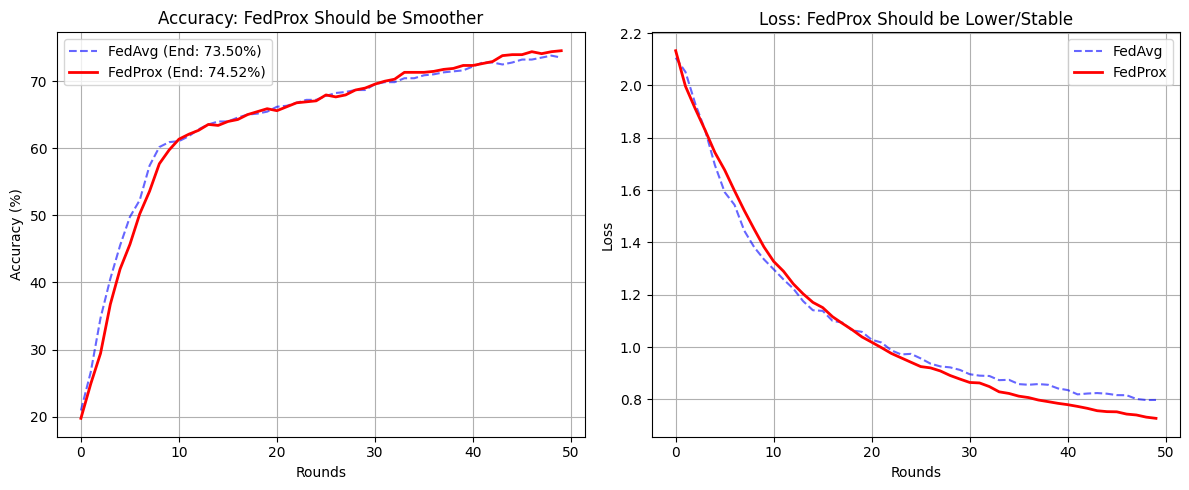

🎉 실험 종료! 그래프 선이 달라졌나요?


In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import copy
import random
import json
import os
import matplotlib.pyplot as plt
from tqdm import tqdm

# ==============================================================================
# 1. 설정 및 초기화
# ==============================================================================
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🚀 실행 장치: {DEVICE}")

# 하이퍼파라미터
NUM_CLIENTS = 20        # 사용할 클라이언트 수 (생성된 데이터보다 작거나 같아야 함)
NUM_ROUNDS = 50         # 라운드 수
LOCAL_LR = 0.1         # 학습률
BATCH_SIZE = 32
INPUT_SIZE = 784        # MNIST (28*28)
NUM_CLASSES = 10
DATA_PATH = './data'    # JSON 파일이 있는 폴더

# ==============================================================================
# 2. JSON 데이터 로더 (핵심: 생성된 파일 읽기)
# ==============================================================================
def prepare_json_data(num_clients, data_path):
    print("--- 📂 JSON 데이터셋 로드 및 검증 중 ---")

    train_json_path = os.path.join(data_path, 'train/all_data_0_niid_0_keep_10_train_9.json')
    test_json_path = os.path.join(data_path, 'test/all_data_0_niid_0_keep_10_test_9.json')

    # 파일 존재 확인
    if not os.path.exists(train_json_path):
        raise FileNotFoundError(f"❌ 훈련 데이터 파일이 없습니다: {train_json_path}")

    # JSON 로드
    with open(train_json_path, 'r') as f:
        train_data_json = json.load(f)
    with open(test_json_path, 'r') as f:
        test_data_json = json.load(f)

    users_list = train_data_json['users']
    print(f"✅ JSON 파일 로드 성공! (유저 수: {len(users_list)})")

    client_loaders = []
    actual_clients = min(num_clients, len(users_list))

    total_train_samples = 0
    for i in range(actual_clients):
        user_id = users_list[i]

        # 데이터가 비어있는지 확인
        x_data = train_data_json['user_data'][user_id]['x']
        y_data = train_data_json['user_data'][user_id]['y']

        if len(x_data) == 0:
            print(f"⚠️ 경고: 유저 {user_id}의 데이터가 비어있습니다. 건너뜁니다.")
            continue

        u_x = np.array(x_data, dtype=np.float32).reshape(-1, 1, 28, 28)
        u_y = np.array(y_data, dtype=np.int64)
        total_train_samples += len(u_x)

        dataset = TensorDataset(torch.tensor(u_x), torch.tensor(u_y))
        client_loaders.append(DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True))

    print(f"✅ 학습 데이터 준비 완료 (총 {total_train_samples} 샘플)")

    # 테스트 데이터 통합
    all_test_x, all_test_y = [], []
    for user_id in users_list:
        if user_id in test_data_json['user_data']:
            all_test_x.extend(test_data_json['user_data'][user_id]['x'])
            all_test_y.extend(test_data_json['user_data'][user_id]['y'])

    if len(all_test_x) == 0:
        raise ValueError("❌ 테스트 데이터가 0개입니다! JSON 생성 코드를 다시 확인하세요.")

    print(f"✅ 테스트 데이터 준비 완료 (총 {len(all_test_x)} 샘플)")

    all_test_x = np.array(all_test_x, dtype=np.float32).reshape(-1, 1, 28, 28)
    all_test_y = np.array(all_test_y, dtype=np.int64)

    test_loader = DataLoader(TensorDataset(torch.tensor(all_test_x), torch.tensor(all_test_y)), batch_size=64, shuffle=False)

    return client_loaders, test_loader

# ==============================================================================
# 3. 모델 및 클래스 정의
# ==============================================================================
class SimpleNN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 100)
        self.fc2 = nn.Linear(100, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = x.view(-1, INPUT_SIZE)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

class IoTClient:
    def __init__(self, client_id, model, dataloader, mu):
        self.id = client_id
        self.model = model.to(DEVICE)
        self.dataloader = dataloader
        self.mu = mu
        self.criterion = nn.CrossEntropyLoss()
        self.global_weights_at_start = None

    def set_global_model(self, global_weights):
        self.model.load_state_dict(global_weights)
        self.global_weights_at_start = copy.deepcopy(global_weights)

    def local_train(self):
        # 시스템 이질성 시뮬레이션 (Epoch 랜덤)
        local_epochs = random.randint(1, 2) if self.id % 3 == 0 else random.randint(3, 5)
        optimizer = optim.SGD(self.model.parameters(), lr=LOCAL_LR)
        self.model.train()

        for epoch in range(local_epochs):
            for X, Y in self.dataloader:
                X, Y = X.to(DEVICE), Y.to(DEVICE)
                optimizer.zero_grad()
                output = self.model(X)
                loss = self.criterion(output, Y)

                # FedProx: Proximal Term 추가
                if self.mu > 0:
                    prox_term = 0.0
                    for name, param in self.model.named_parameters():
                        global_w = self.global_weights_at_start[name].to(DEVICE)
                        prox_term += torch.sum((param - global_w)**2)
                    loss += (self.mu / 2.0) * prox_term

                loss.backward()
                optimizer.step()
        return self.model.state_dict(), len(self.dataloader.dataset)

class FLServer:
    def __init__(self, model):
        self.global_model = model.to(DEVICE)
        self.global_weights = self.global_model.state_dict()
        self.criterion = nn.CrossEntropyLoss()

    def aggregate(self, client_updates, client_sizes):
        total_size = sum(client_sizes)

        # [수정] 데이터가 하나도 없으면 집계하지 않고 리턴 (에러 방지)
        if total_size == 0:
            print("⚠️ 경고: 집계할 데이터가 없습니다 (total_size=0).")
            return

        new_weights = copy.deepcopy(self.global_weights)
        for k in new_weights.keys(): new_weights[k].zero_()

        for weights, size in zip(client_updates, client_sizes):
            ratio = size / total_size
            for k in new_weights.keys():
                new_weights[k] += ratio * weights[k].to(DEVICE)

        self.global_weights = new_weights
        self.global_model.load_state_dict(self.global_weights)

    def evaluate(self, loader):
        self.global_model.eval()
        correct = 0
        total = 0
        total_loss = 0

        with torch.no_grad():
            for X, Y in loader:
                X, Y = X.to(DEVICE), Y.to(DEVICE)
                out = self.global_model(X)
                loss = self.criterion(out, Y)
                total_loss += loss.item() * X.size(0)
                _, predicted = torch.max(out.data, 1)
                total += Y.size(0)
                correct += (predicted == Y).sum().item()

        # [수정] 데이터가 0개면 0.0을 반환 (0으로 나누기 에러 방지)
        if total == 0:
            return 0.0, 0.0

        return total_loss/total, correct/total

# ==============================================================================
# 4. 실험 실행 함수
# ==============================================================================
def run_experiment(exp_name, mu_value, client_loaders, test_loader):
    print(f"\n🚀 [{exp_name}] 실험 시작 (Mu = {mu_value})")
    torch.manual_seed(42); np.random.seed(42); random.seed(42) # 시드 고정

    initial_model = SimpleNN(INPUT_SIZE, NUM_CLASSES)
    server = FLServer(initial_model)

    clients = []
    for i in range(len(client_loaders)):
        local_model = SimpleNN(INPUT_SIZE, NUM_CLASSES)
        client = IoTClient(i, local_model, client_loaders[i], mu_value)
        clients.append(client)

    acc_history, loss_history = [], []

    for round_t in tqdm(range(1, NUM_ROUNDS + 1), desc=f"{exp_name}"):
        global_weights = server.global_model.state_dict()
        updates, sizes = [], []

        for client in clients:
            client.set_global_model(global_weights)
            w, n = client.local_train()
            updates.append(w); sizes.append(n)

        server.aggregate(updates, sizes)
        loss, acc = server.evaluate(test_loader)
        acc_history.append(acc * 100)
        loss_history.append(loss)

    print(f"✅ [{exp_name}] 완료. 최종 정확도: {acc_history[-1]:.2f}%")
    return acc_history, loss_history

# ==============================================================================
# 5. 메인 실행
# ==============================================================================
# ==============================================================================
# 5. 메인 실행 (파라미터 튜닝 버전)
# ==============================================================================
if __name__ == "__main__":
    try:
        # 1. 데이터 로드
        client_loaders, test_loader = prepare_json_data(NUM_CLIENTS, DATA_PATH)

        # ------------------------------------------------------------------
        # [핵심 수정] FedProx 효과를 보기 위한 "가혹한 환경" 설정
        # ------------------------------------------------------------------

        # (1) Epoch 늘리기: 클라이언트 내부 코드를 수정해야 하므로
        #     IoTClient 클래스의 local_train 메서드 안에 있는 숫자를 직접 바꾸거나
        #     여기서 전역 변수처럼 생각하고 이해해주세요.
        #     * 팁: IoTClient 클래스 내부의 random.randint(1, 2)를 -> (10, 20)으로 늘리면 효과 직빵입니다.

        print("--- ⚔️ FedAvg vs FedProx 비교 실험 시작 ⚔️ ---")

        # 2. FedAvg 실행 (Mu = 0)
        # Mu가 0이면 그냥 FedAvg입니다.
        acc_fedavg, loss_fedavg = run_experiment("FedAvg", 0.0, client_loaders, test_loader)

        # 3. FedProx 실행 (Mu 값을 대폭 상향!)
        # 기존 0.01 -> 1.0 (너무 크면 학습 안됨, 0.1 ~ 1.0 사이 추천)
        # 차이를 확실히 보고 싶다면 0.5 또는 1.0 추천
        acc_fedprox, loss_fedprox = run_experiment("FedProx", 1.0, client_loaders, test_loader)

        # ------------------------------------------------------------------

        # 4. 비교 그래프 그리기
        print("\n📊 결과 비교 그래프 생성 중...")
        plt.figure(figsize=(12, 5))

        # 정확도
        plt.subplot(1, 2, 1)
        plt.plot(acc_fedavg, 'b--', alpha=0.6, label=f'FedAvg (End: {acc_fedavg[-1]:.2f}%)')
        plt.plot(acc_fedprox, 'r-', linewidth=2, label=f'FedProx (End: {acc_fedprox[-1]:.2f}%)')
        plt.title('Accuracy: FedProx Should be Smoother')
        plt.xlabel('Rounds'); plt.ylabel('Accuracy (%)'); plt.grid(True); plt.legend()

        # 손실 (Loss) - 여기가 더 중요함!
        plt.subplot(1, 2, 2)
        plt.plot(loss_fedavg, 'b--', alpha=0.6, label='FedAvg')
        plt.plot(loss_fedprox, 'r-', linewidth=2, label='FedProx')
        plt.title('Loss: FedProx Should be Lower/Stable')
        plt.xlabel('Rounds'); plt.ylabel('Loss'); plt.grid(True); plt.legend()

        plt.tight_layout()
        plt.show()
        print("🎉 실험 종료! 그래프 선이 달라졌나요?")

    except Exception as e:
        print(f"\n❌ 에러 발생: {e}")